Select Control Scheme :
1. Simple PD Control
2. PD Control with Gravity Compensation
3. PD Control with Feed-forward term
4. Computed Torrque PD Control

Press a button from 1 - 4 : 4


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


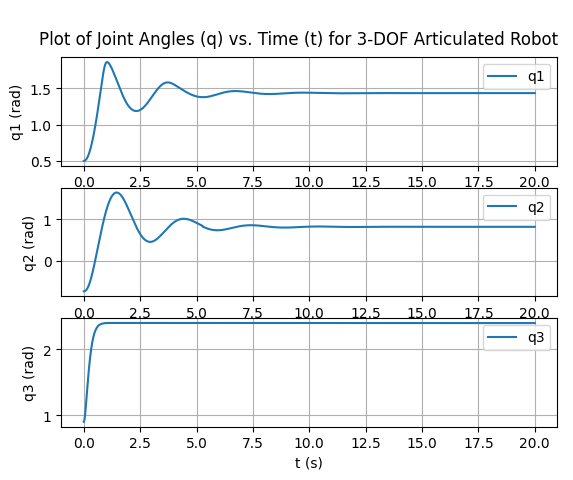

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Robot parameters (masses,linklengths,gravity)
robot_parameters = {
    'm1': 2.0,
    'm2': 1.5,
    'm3': 0.8,
    'l2': 1.5,
    'l3': 0.8,
    'lc2': 0.5,
    'lc3': 0.5,
    'g': 9.817,
}

# Motor dynamics parameters (inertias,damping coefficients,resistances,inductances,back-emf constants, torque constants)
motor_parameters = {
    'Jm': np.array([0.9, 1.25, 0.75]),
    'Bm': np.array([2, 2.5, 3]),
    'Rm': np.array([0.95, 1.25, 0.75]),
    'Lm': np.array([0.012, 0.025, 0.0049]),
    'Kb': np.array([0.201, 0.2501, 0.101]),
    'Kt': np.array([0.10, 0.301, 0.401]),
}

# Motor control parameters
control_parameters = {
    'Kp': np.array([9.95, 10.05, 10.1]),
    'Kd': np.array([1.99, 2.17, 2.5]),
}

# Function for Motor Control
def motor_control(choice, q, q_dot, q_desired, q_dot_desired, M, C, G, Kp, Kd):
    if choice == '1':
        tau_motor_desired = Kp * (q_desired - q) + Kd * (q_dot_desired - q_dot)
    elif choice == '2':
        tau_motor_desired = M.dot(q_ddot_desired) + C.dot(q_dot_desired) + G + Kp * (q_desired - q) + Kd * (q_dot_desired - q_dot)
    elif choice == '3':
        feedforward_term = M.dot(q_ddot_desired)
        tau_motor_desired = feedforward_term + Kp * (q_desired - q) + Kd * (q_dot_desired - q_dot)
    elif choice == '4':
        feedforward_term = M.dot(q_ddot_desired)
        tau_desired = feedforward_term + M.dot(q_ddot_desired) + C.dot(q_dot_desired) + G
        tau_motor_desired = tau_desired + Kp * (q_desired - q) + Kd * (q_dot_desired - q_dot)

    return tau_motor_desired

# Calculate dynamics
def calculate_dynamics(q):
    C2, S2, C3, S3, C23, S23 = np.cos(q[1]), np.sin(q[1]), np.cos(q[2]), np.sin(q[2]), np.cos(q[1] + q[2]), np.sin(q[1] + q[2])

    M = np.array([
        [(1/2 * robot_parameters['m1'] * robot_parameters['lc2']**2 + 1/4 * robot_parameters['m2'] * robot_parameters['l2']**2 * C2**2 + 1/4 * robot_parameters['m3'] * robot_parameters['l3']**2 * C23**2 + robot_parameters['m3'] * robot_parameters['l2']**2 * C2**2 + robot_parameters['m2'] * robot_parameters['l2'] * robot_parameters['l3'] * C2 * C23), 0, 0],
        [0, (1/4 * robot_parameters['m2'] * robot_parameters['l2']**2 + robot_parameters['m3'] * (robot_parameters['l2']**2 + robot_parameters['lc3']**2 + robot_parameters['l2'] * robot_parameters['l3'] * C3)), 0],
        [0, 0, (1/3 * robot_parameters['m3'] * robot_parameters['l3']**2)]
    ])

    C = np.array([
        [0, (-1/4 * robot_parameters['m2'] * robot_parameters['l2']**2 * S2 - robot_parameters['m3'] * robot_parameters['l2']**2 * S2 - robot_parameters['m3'] * robot_parameters['l2'] * robot_parameters['l3'] * S23 - robot_parameters['m3'] * robot_parameters['lc2']**2 * S23), (-robot_parameters['m3'] * robot_parameters['l2'] * robot_parameters['l3'] * C2 * S23 - robot_parameters['m3'] * robot_parameters['lc3']**2 * S23)],
        [0, 0, -robot_parameters['m2'] * robot_parameters['l2'] * robot_parameters['l3'] * S3],
        [0, 0, 0]
    ])

    G = np.array([
        robot_parameters['lc2'] * robot_parameters['m2'] * robot_parameters['g'] * C2 + robot_parameters['l2'] * robot_parameters['m3'] * robot_parameters['g'] * C2 + robot_parameters['lc3'] * robot_parameters['m2'] * robot_parameters['g'] * C23,
        0,
        robot_parameters['m3'] * robot_parameters['g'] * robot_parameters['lc3'] * C23
    ])

    return M, C, G

# Initial conditions
initial_conditions = {
    'q': np.array([0.5, -0.75, 0.9]),
    'q_dot': np.array([0.0, 0.0, 0.0]),
    'q_dot_motor': np.array([0.0, 0.0, 0.0]),
    'I_motor': np.array([0.0, 0.0, 0.0]),
}

# Desired joint angles, velocities, and accelerations
q_desired = np.array([1.5, 0.7, 2.3])
q_dot_desired = np.array([0.3, 0.7, 0.4])
q_ddot_desired = np.array([0.06, 0.08, 0.10])

# Simulation parameters
t_max = 20.0
num_steps = 10000
dt = t_max / num_steps
time_values = np.linspace(0, t_max, num_steps)

# Combined inertial and motor dynamics function
def dynamics(state, t, choice):
    q, q_dot, q_dot_motor, I_motor = np.split(state, 4)
    q_ddot_motor = np.zeros(3)
    I_dot_motor = np.zeros(3)
    tau_motor_desired = np.zeros(3)
    tau_motor = np.zeros(3)
    V_back = np.zeros(3)
    V_motor = np.zeros(3)

    M, C, G = calculate_dynamics(q)

    tau_motor_desired = motor_control(choice, q, q_dot, q_desired, q_dot_desired, M, C, G, control_parameters['Kp'], control_parameters['Kd'])

    V_back = motor_parameters['Kb'] * q_dot_motor
    I_motor = tau_motor_desired / (motor_parameters['Kt'] * motor_parameters['Rm'])
    q_ddot_motor = (tau_motor_desired - motor_parameters['Bm'] * q_dot_motor - motor_parameters['Kt'] * I_motor) / motor_parameters['Jm']
    q_dot_motor += q_ddot_motor * dt
    V_motor = I_motor * motor_parameters['Rm']
    I_dot_motor = (V_motor - motor_parameters['Rm'] * I_motor - V_back) / motor_parameters['Lm']
    tau_motor = V_motor * motor_parameters['Kt']

    q_ddot = np.linalg.solve(M, (tau_motor - np.dot(C, q_dot)) - G)

    return np.concatenate([q_dot, q_ddot, q_ddot_motor, I_dot_motor])

# Initial conditions for the ODE solver
state_0 = np.concatenate((initial_conditions['q'], initial_conditions['q_dot'], initial_conditions['q_dot_motor'], initial_conditions['I_motor']))

print("Select Control Scheme :\n1. Simple PD Control\n2. PD Control with Gravity Compensation\n3. PD Control with Feed-forward term\n4. Computed Torrque PD Control")
choice = input("\nPress a button from 1 - 4 : ")
# Use odeint to integrate the ODE
solution = odeint(dynamics, state_0, time_values, args=(choice,))

# Extract the joint angles from the solution
q1_values = solution[:, 0]
q2_values = solution[:, 1]
q3_values = solution[:, 2]

# Plot the joint angles over time
plt.figure()
plt.suptitle(f"\nPlot of Joint Angles (q) vs. Time (t) for 3-DOF Articulated Robot ")

plt.subplot(311)
plt.plot(time_values, q1_values, label='q1')
plt.xlabel('t (s)')
plt.ylabel('q1 (rad)')
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(time_values, q2_values, label='q2')
plt.xlabel('t (s)')
plt.ylabel('q2 (rad)')
plt.grid()
plt.legend()

plt.subplot(313)
plt.plot(time_values, q3_values, label='q3')
plt.xlabel('t (s)')
plt.ylabel('q3 (rad)')
plt.grid()
plt.legend()

plt.show()
